##### Install and Import Dependencies

In [ ]:
!pip list

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

#####  Build Data Loading Functions

In [3]:
import gdown # grab date from google drive

In [4]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=be73143a-c1a3-4a32-b149-b3478672f554
To: C:\Users\USER\data.zip
100%|███████████████████████████████████████████████████████████████████████████████| 423M/423M [01:42<00:00, 4.12MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [5]:
def load_video(path:str) -> List[float]:
    
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 89:220, :])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) /std

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab, oov_token = "")
num_to_char = tf.keras.layers.StringLookup(vocabulary = char_to_num.get_vocabulary(), oov_token = "", invert = True)

print(
      f"The vocabulary is: {char_to_num.get_vocabulary()}"
      f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [16]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [17]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [11]:
test_path ='.\\data\\s1\\bbal6n.mpg'

In [14]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [18]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 131, 1), dtype=float32, numpy=
 array([[[[ 1.3960369 ],
          [ 1.4359237 ],
          [ 1.4359237 ],
          ...,
          [ 0.2393206 ],
          [ 0.27920738],
          [ 0.15954708]],
 
         [[ 1.3960369 ],
          [ 1.4359237 ],
          [ 1.4359237 ],
          ...,
          [ 0.2393206 ],
          [ 0.15954708],
          [ 0.1196603 ]],
 
         [[ 1.3960369 ],
          [ 1.3561502 ],
          [ 1.3561502 ],
          ...,
          [ 0.15954708],
          [ 0.15954708],
          [ 0.15954708]],
 
         ...,
 
         [[ 0.9572824 ],
          [ 0.9572824 ],
          [ 0.9971692 ],
          ...,
          [10.131239  ],
          [10.051466  ],
          [10.051466  ]],
 
         [[ 0.9572824 ],
          [ 0.9572824 ],
          [ 0.9572824 ],
          ...,
          [10.091352  ],
          [10.051466  ],
          [10.051466  ]],
 
         [[ 0.9572824 ],
          [ 0.9572824 ],
          [ 0.9572824 ],
          

In [22]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

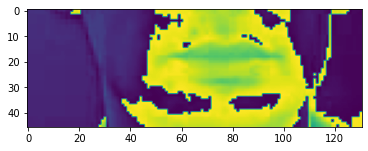

In [20]:
plt.imshow(frames[0])

In [23]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [25]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [26]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

##### Create Data Pipeline

In [27]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes = ([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [28]:
test = data.as_numpy_iterator()

In [29]:
val = test.next(); val[0]

array([[[[[1.3025557 ],
          [1.1876243 ],
          [1.2259347 ],
          ...,
          [9.1562    ],
          [9.730857  ],
          [0.15324184]],

         [[1.2259347 ],
          [1.1493138 ],
          [1.1876243 ],
          ...,
          [9.2711315 ],
          [9.730857  ],
          [0.15324184]],

         [[1.417487  ],
          [1.3791766 ],
          [1.3791766 ],
          ...,
          [9.769168  ],
          [0.1915523 ],
          [0.1915523 ]],

         ...,

         [[0.996072  ],
          [0.996072  ],
          [0.996072  ],
          ...,
          [0.07662092],
          [0.07662092],
          [0.07662092]],

         [[0.9577615 ],
          [0.9577615 ],
          [0.9577615 ],
          ...,
          [0.03831046],
          [0.03831046],
          [0.03831046]],

         [[0.9577615 ],
          [0.9577615 ],
          [0.9577615 ],
          ...,
          [0.03831046],
          [0.03831046],
          [0.        ]]],


        [[[1.4557

In [30]:
imageio.mimsave('./animation.gif', val[0][1], fps = 10)

Lossy conversion from float32 to uint8. Range [0.0, 9.983393669128418]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.983393669128418]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.983393669128418]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.983393669128418]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.983393669128418]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.983393669128418]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.983393669128418]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

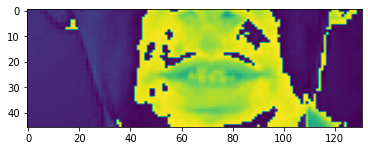

In [31]:
# 0: videos, 0:1st vide out of the batch, 0: return the first frame in the video

plt.imshow(val[0][0][35])

In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place red at c nine again'>

#### Design the Deep Neural Network

In [33]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [34]:
data.as_numpy_iterator().next()[0][0].shape # we will add exactly same values to first conv3D model

(75, 46, 131, 1)

In [41]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,131,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [42]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [46]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'kkkkkkkkkkkkkkkkkzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzkkkkkkkkkkkkkkkkkkxxxxxxx'>

In [45]:
yhat[0].shape

(75, 41)

In [47]:
model.input_shape

(None, 75, 46, 131, 1)

In [49]:
model.output_shape

(None, 75, 41)

#### Training Options and Test 

In [50]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [51]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [64]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [72]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = CTCLoss)

In [54]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor='loss', save_weights_only=True)

In [59]:
schedule_callback = LearningRateScheduler(scheduler)

In [56]:
example_callback = ProduceExample(data)

In [61]:
# added late. this is for data pipeline

train = data.take(450)
test = data.skip(450)

In [65]:
model.fit(train, validation_data=test, epochs = 50, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/50
  7/450 [..............................] - ETA: 3:27:04 - loss: 114.7078

KeyboardInterrupt: 

#### Make Prediction

In [70]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=6e985f06-1d17-4858-af34-190c44087176
To: C:\Users\USER\checkpoints.zip
100%|█████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:22<00:00, 4.24MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [ ]:
model.load_weights('models/checkpoint')

In [74]:
test_data = test.as_numpy_iterator()

In [75]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

#### Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]